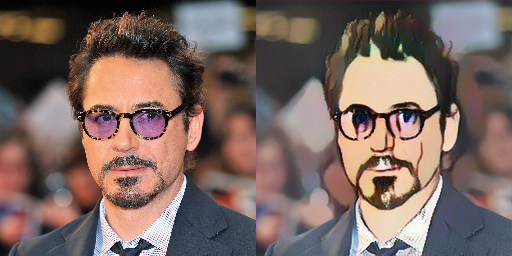

In [40]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from torch.nn import functional as F




class ResBlock(nn.Module):
    def __init__(self, num_channel):
        super(ResBlock, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(num_channel, num_channel, 3, 1, 1),
            nn.BatchNorm2d(num_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channel, num_channel, 3, 1, 1),
            nn.BatchNorm2d(num_channel))
        self.activation = nn.ReLU(inplace=True)

    def forward(self, inputs):
        output = self.conv_layer(inputs)
        output = self.activation(output + inputs)
        return output


class DownBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DownBlock, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, 2, 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True))


    def forward(self, inputs):
        output = self.conv_layer(inputs)
        return output


class UpBlock(nn.Module):
    def __init__(self, in_channel, out_channel, is_last=False):
        super(UpBlock, self).__init__()
        self.is_last = is_last
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 3, 1, 1),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channel, out_channel, 3, 1, 1))
        self.act = nn.Sequential(
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True))
        self.last_act = nn.Tanh()


    def forward(self, inputs):
        output = self.conv_layer(inputs)
        if self.is_last:
            output = self.last_act(output)
        else:
            output = self.act(output)
        return output



class Generator(nn.Module):
    def __init__(self, num_channel=32, num_blocks=4):
        super(Generator, self).__init__()
        self.down1 = DownBlock(3, num_channel)
        self.down2 = DownBlock(num_channel, num_channel*2)
        self.down3 = DownBlock(num_channel*2, num_channel*3)
        self.down4 = DownBlock(num_channel*3, num_channel*4)
        res_blocks = [ResBlock(num_channel*4)]*num_blocks
        self.res_blocks = nn.Sequential(*res_blocks)
        self.up1 = UpBlock(num_channel*4, num_channel*3)
        self.up2 = UpBlock(num_channel*3, num_channel*2)
        self.up3 = UpBlock(num_channel*2, num_channel)
        self.up4 = UpBlock(num_channel, 3, is_last=True)

    def forward(self, inputs):
        down1 = self.down1(inputs)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        down4 = self.res_blocks(down4)
        up1 = self.up1(down4)
        up2 = self.up2(up1+down3)
        up3 = self.up3(up2+down2)
        up4 = self.up4(up3+down1)
        return up4



weight = torch.load('weight.pth', map_location='cpu')
model = Generator()
model.load_state_dict(weight)
#torch.save(model.state_dict(), 'weight.pth')
model.eval()
raw_image = cv2.imread('/content/12.jpg')
raw_image = cv2.resize(raw_image,(256,256))
image = raw_image/127.5 - 1
image = image.transpose(2, 0, 1)
image = torch.tensor(image).unsqueeze(0)
output = model(image.float())
output = output.squeeze(0).detach().numpy()
output = output.transpose(1, 2, 0)
output = (output + 1) * 127.5
output = np.clip(output, 0, 255).astype(np.uint8)
output = np.concatenate([raw_image, output], axis=1)
cv2_imshow(output)        

In [ ]:
!pip install onnx
!pip install tensorflow-addons
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e . 

In [2]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import onnx
from onnx_tf.backend import prepare
dummy_input = Variable(torch.randn(1, 3, 256, 256))
torch.onnx.export(model, dummy_input, "model.onnx")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:385: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  "" + str(_export_onnx_opset_version) + ". "


In [3]:
model = onnx.load('model.onnx')
tf_rep = prepare(model)

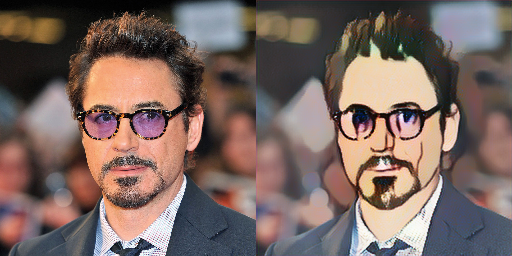

In [39]:
raw_image = cv2.imread('/content/12.jpg')
raw_image = cv2.resize(raw_image,(256,256))
image = raw_image/127.5 - 1
image = image.transpose(2, 0, 1)
image = torch.tensor(image).unsqueeze(0)
output = tf_rep.run(image.float())
output = np.asarray(output)[0][0]
output = output.transpose(1, 2, 0)
output = (output + 1) * 127.5
output = np.clip(output, 0, 255).astype(np.uint8)
output = np.concatenate([raw_image, output], axis=1)
cv2_imshow(output)

In [24]:
tf_rep.export_graph('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
